In [1]:
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd

from string import digits 
remove_digits = str.maketrans('', '', digits)

import pycountry_convert as pc_conv
import pycountry as pc

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import plotly.express as px

## 1. Fazendo o Web Scraping dos dados

* Será primeiro extraído os links para a página específica de cada jogador, para 5 ligas diferentes(Bundesliga, EPL, La Liga, Serie A, Ligue 1);
* Logo em seguida será extraída as informações de cada jogador através dos links da etapa aterior;

Exemplo de informações a serem extraídas da página: https://sofifa.com/player/188545/robert-lewandowski/200059/

<img src="exemplo.png" alt="Informações a serem extraídas" width="700"/>

### 1.1. Extraindo o link dos jogadores

In [5]:
link_players = []
ligas_url = ['https://sofifa.com/players?type=all&lg%5B0%5D=19&offset=', 'https://sofifa.com/players?type=all&lg%5B0%5D=13&offset=', 
             'https://sofifa.com/players?type=all&lg%5B0%5D=53&offset=', 'https://sofifa.com/players?type=all&lg%5B0%5D=31&offset=',
            'https://sofifa.com/players?type=all&lg%5B0%5D=16&offset=']
ligas = ['Bundesliga', 'EPL', 'La Liga', 'Serie A', 'Ligue 1']

for liga, url in tqdm(zip(ligas, ligas_url), total=len(ligas)):
    #print(liga)
    for pag in np.arange(0,5000,60):
        #print(pag)
        url_players = url + str(pag)
        response = requests.get(url_players)
        if response.url == 'https://sofifa.com/players':
            break

        html = BeautifulSoup(response.text, "html.parser")
        table = html.find_all('tbody',attrs={'class':'list'})

        links = table[0].find_all('a', attrs={'class':'tooltip'})
        for link in links:
            try:
                l = link.get('href')
                #print([l, liga])
                link_players.append([l, liga])    
            except:
                pass

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:34<00:00,  6.88s/it]


In [6]:
links_df = pd.DataFrame(link_players)
links_df.columns = ['link', 'liga']
links_df.to_csv('./data/link_players.csv', index=False)

In [7]:
links_df

,link,liga
0,/player/188545/robert-lewandowski/200059/,Bundesliga
1,/player/167495/manuel-neuer/200059/,Bundesliga
2,/player/212622/joshua-kimmich/200059/,Bundesliga
3,/player/178603/mats-hummels/200059/,Bundesliga
4,/player/188350/marco-reus/200059/,Bundesliga
...,...,...
2936,/player/251340/ahmadou-dia/200059/,Ligue 1
2937,/player/252227/florentin-bloch/200059/,Ligue 1
2938,/player/254021/valentin-rabouille/200059/,Ligue 1
2939,/player/254662/ewan-hatfout/200059/,Ligue 1


### 1.2. Extraindo as informações de cada jogador

Será extraído 14 informações de cada jogar:
* **Id**: Id do jogador
* **Name**: Nome abreviado
* **Full Name**: Nome completo
* **Country**: País de nascimento
* **Birth**: Data de nascimento
* **Height**: Altura
* **Weight**: Peso
* **Foot**: Pé preferido
* **Team**: Time atual
* **Jersey**: Número da camisa
* **League**: Liga atual
* **Formation**: Posições preferidas
* **Value**: Valor de mercado
* **Wage**: Salário atual

In [8]:
links = links_df['link'].values
ligas = links_df['liga'].values

In [9]:
# Iniciando a lista com as informações dos jogadores
info_players = []

# Iniciando a extração das informações
i = 0
for link, liga in tqdm(zip(links, ligas), total=len(links)):
    i += 1
    #print(i, link)
    try:
        url = f'https://sofifa.com/{link}'
        response = requests.get(url)

        html = BeautifulSoup(response.text, "html.parser")
        
        name = html.find('h1').text.strip()

        info = html.find('div',attrs={'class':'bp3-card player'})
        name_info = info.find('h1').text
        Id = re.search('[(]ID: (.*)[)]', name_info).group(1)
        full_name = name_info.split(' (')[0]
        info2 = info.find('div', attrs={'class':'meta bp3-text-overflow-ellipsis'})
        
        data = info2.text
        data2 = info.find('section', attrs={'class':'spacing'}).find_all('div', attrs={'class':'col-3'})
        data3 = html.find('div',attrs={'class':'column col-12'})
        data4 = html.find('div',attrs={'class':'player-card double-spacing'})

        pos = data.split('y.o.')[0].translate(remove_digits).strip()
        birth = re.search('[(](.*)[)]', data).group(1)
        num = re.search('[)] (.*) ', data).group(1).split("\'")
        h = int((int(num[0])*12 + int(num[1].replace('"','')))*2.54)
        w = int(int(data.split('"')[1].strip().replace('lbs',''))*0.453592)

        value = data2[2].text.split('Value')[0]
        wage = data2[3].text.split('Wage')[0]
        team = html.find('div',attrs={'class':'player-card double-spacing'}).find('h5').text
        country = info2.find('a').get('title')

        foot = data3.find('li').text.split('Foot')[1]
        jersey = data4.find_all('li')[2].text.split('Number')[1]

        #print([Id, name, full_name, country, birth, h, w, foot, team, jersey, liga, pos, value, wage])
        info_players.append([Id, name, full_name, country, birth, h, w, foot, team, jersey, liga, pos, value, wage])
    except:
        pass

100%|██████████████████████████████████████████████████████████████████████████████| 2941/2941 [19:25<00:00,  2.52it/s]


In [10]:
players_df = pd.DataFrame(info_players)
players_df.columns = ['id', 'name', 'full name', 'country', 'birth', 'height', 'weight', 'foot', 'team', 'jersey', 'league', 'formation', 'value', 'wage']
players_df.to_csv('./data/players_info_raw.csv', index=False)

In [11]:
players_df

,id,name,full name,country,birth,height,weight,foot,team,jersey,league,formation,value,wage
0,188545,R. Lewandowski,Robert Lewandowski,Poland,"Aug 21, 1988",182,79,Right,FC Bayern München,9,Bundesliga,ST,€86M,€300K
1,167495,M. Neuer,Manuel Neuer,Germany,"Mar 27, 1986",193,92,Right,FC Bayern München,1,Bundesliga,GK,€36M,€160K
2,212622,J. Kimmich,Joshua Kimmich,Germany,"Feb 8, 1995",175,73,Right,FC Bayern München,32,Bundesliga,CDM RB CM,€58M,€135K
3,178603,M. Hummels,Mats Hummels,Germany,"Dec 16, 1988",190,93,Right,Borussia Dortmund,15,Bundesliga,CB,€41M,€125K
4,188350,M. Reus,Marco Reus,Germany,"May 31, 1989",180,71,Right,Borussia Dortmund,11,Bundesliga,CAM CF,€47.5M,€140K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,251340,A. Dia,Ahmadou Bamba Dia,France,"Oct 13, 1999",182,78,Right,Olympique de Marseille,40,Ligue 1,GK,€140K,€1K
2937,252227,F. Bloch,Florentin Bloch,France,"Feb 2, 2000",190,78,Left,Toulouse Football Club,16,Ligue 1,GK,€120K,€1K
2938,254021,V. Rabouille,Valentin Rabouille,France,"Apr 15, 2000",187,79,Right,Nîmes Olympique,40,Ligue 1,GK,€100K,€1K
2939,254662,E. Hatfout,Ewan Hatfout,France,"Apr 1, 2000",193,78,Right,Dijon FCO,40,Ligue 1,GK,€120K,€650


### 1.3. Limpando e criando novas variáveis

* Transformando a variável **Value** para o formato int:

In [12]:
values = players_df['value'].values
for i in range(len(values)):
    if values[i][-1] == 'M':
        players_df.loc[i,'value'] = float(values[i].replace('€','')[:-1])*(10**6)
    elif values[i][-1] == 'K':
        players_df.loc[i,'value'] = float(values[i].replace('€','')[:-1])*(10**3)
    else:
        players_df.loc[i,'value'] = float(values[i].replace('€',''))

* Transformando a variável **Wage** para o formato int:

In [13]:
wages = players_df['wage'].values
for i in range(len(wages)):
    if wages[i][-1] == 'M':
        players_df.loc[i,'wage'] = float(wages[i].replace('€','')[:-1])*(10**6)
    elif wages[i][-1] == 'K':
        players_df.loc[i,'wage'] = float(wages[i].replace('€','')[:-1])*(10**3)
    else:
        players_df.loc[i,'wage'] = float(wages[i].replace('€',''))

* Criando uma nova variável **Position** com a posição de destaque do jogador em **Formation**:

In [14]:
Gk = ['GK']
Df = ['LCB', 'CB', 'RCB', 'LB', 'RB', 'LWB', 'RWB']
Md = ['LDM', 'CDM', 'RDM', 'LM', 'LCM', 'CM', 'RCM', 'RM','LAM','CAM','RAM']
At = ['LW', 'LF', 'CF', 'RF', 'RW', 'LS', 'ST', 'RS']

form = players_df['formation'].values

pos = []
for f in form:
    p = f.split(' ')[0]
    if p in Gk:
        pos.append('Goalkepper')
    elif p in Df:
        pos.append('Defender')
    elif p in Md:
        pos.append('Midfielder')
    elif p in At:
        pos.append('Attacker')
    else:
        pos.append('')
        
players_df['position'] = pos

* Corrigindo o nome de alguns países e criando uma nova variável **Continent** com a lib **pycountry**:

In [15]:
country1 = ['Bosnia Herzegovina','Republic of Ireland','Ivory Coast','DR Congo','Guinea Bissau',
            'Cape Verde','Korea Republic','China PR','Macau']
country2 = ['Bosnia and Herzegovina','Ireland',"Côte d'Ivoire",'Congo','Guinea-Bissau',
           'Cabo Verde','Republic of Korea','China','Macao']

for i in range(len(country1)):
    players_df.loc[players_df['country'] == country1[i],'country'] = country2[i]
    

continents = {'NA': 'North America','SA': 'South America','AS': 'Asia','OC': 'Oceania','AF': 'Africa', 'EU':'Europe'}
countries = players_df['country'].values

cont = []
for country in countries:
    c = continents[pc_conv.country_alpha2_to_continent_code(pc.countries.search_fuzzy(country)[0].alpha_2)]
    #print(country, c)
    cont.append(c)
    
players_df['continent'] = cont

* Criando a variável **Age** usando **Birth**:

In [16]:
players_df['birth'] = pd.to_datetime(players_df['birth'])

age = []

today = datetime.datetime.today() 
birth = players_df['birth']

for b in birth:
    age.append(today.year - b.year - ((today.month, today.day) < (b.month, b.day)))
    
players_df['age'] = age

* Salvando a base de dados em formato CSV:

In [17]:
players_df.to_csv('./data/players_info_final.csv', index=False)

## 2 Análise Exploratória dos Dados

In [2]:
df = pd.read_csv('./data/players_info_final.csv')
df['id'] = df['id'].astype('object')
df['birth'] = pd.to_datetime(df['birth'])

In [3]:
df

,id,name,full name,country,birth,height,weight,foot,team,jersey,league,formation,value,wage,position,continent,age
0,188545,R. Lewandowski,Robert Lewandowski,Poland,1988-08-21,182,79,Right,FC Bayern München,9,Bundesliga,ST,86000000.0,300000.0,Attacker,Europe,32
1,167495,M. Neuer,Manuel Neuer,Germany,1986-03-27,193,92,Right,FC Bayern München,1,Bundesliga,GK,36000000.0,160000.0,Goalkepper,Europe,34
2,212622,J. Kimmich,Joshua Kimmich,Germany,1995-02-08,175,73,Right,FC Bayern München,32,Bundesliga,CDM RB CM,58000000.0,135000.0,Midfielder,Europe,25
3,178603,M. Hummels,Mats Hummels,Germany,1988-12-16,190,93,Right,Borussia Dortmund,15,Bundesliga,CB,41000000.0,125000.0,Defender,Europe,31
4,188350,M. Reus,Marco Reus,Germany,1989-05-31,180,71,Right,Borussia Dortmund,11,Bundesliga,CAM CF,47500000.0,140000.0,Midfielder,Europe,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2936,251340,A. Dia,Ahmadou Bamba Dia,France,1999-10-13,182,78,Right,Olympique de Marseille,40,Ligue 1,GK,140000.0,1000.0,Goalkepper,Europe,20
2937,252227,F. Bloch,Florentin Bloch,France,2000-02-02,190,78,Left,Toulouse Football Club,16,Ligue 1,GK,120000.0,1000.0,Goalkepper,Europe,20
2938,254021,V. Rabouille,Valentin Rabouille,France,2000-04-15,187,79,Right,Nîmes Olympique,40,Ligue 1,GK,100000.0,1000.0,Goalkepper,Europe,20
2939,254662,E. Hatfout,Ewan Hatfout,France,2000-04-01,193,78,Right,Dijon FCO,40,Ligue 1,GK,120000.0,650.0,Goalkepper,Europe,20


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2941 entries, 0 to 2940
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         2941 non-null   object        
 1   name       2941 non-null   object        
 2   full name  2941 non-null   object        
 3   country    2941 non-null   object        
 4   birth      2941 non-null   datetime64[ns]
 5   height     2941 non-null   int64         
 6   weight     2941 non-null   int64         
 7   foot       2941 non-null   object        
 8   team       2941 non-null   object        
 9   jersey     2941 non-null   int64         
 10  league     2941 non-null   object        
 11  formation  2941 non-null   object        
 12  value      2941 non-null   float64       
 13  wage       2941 non-null   float64       
 14  position   2941 non-null   object        
 15  continent  2941 non-null   object        
 16  age        2941 non-null   int64         


In [5]:
df.describe()

,height,weight,jersey,value,wage,age
count,2941.000000,2941.000000,2941.000000,2.941000e+03,2941.000000,2941.000000
mean,181.877253,75.701462,21.772186,8.353890e+06,32330.907854,25.766406
std,6.529699,7.068226,16.431401,1.125472e+07,42606.980483,4.677291
min,162.000000,55.000000,1.000000,0.000000e+00,500.000000,17.000000
25%,177.000000,71.000000,10.000000,1.100000e+06,8000.000000,22.000000
50%,182.000000,76.000000,19.000000,5.000000e+06,21000.000000,25.000000
75%,187.000000,79.000000,29.000000,1.050000e+07,38000.000000,29.000000
max,203.000000,101.000000,99.000000,1.055000e+08,560000.000000,43.000000


### 2.1. Quantidade de jogadores por Continente, Liga, Posição e Pé preferido

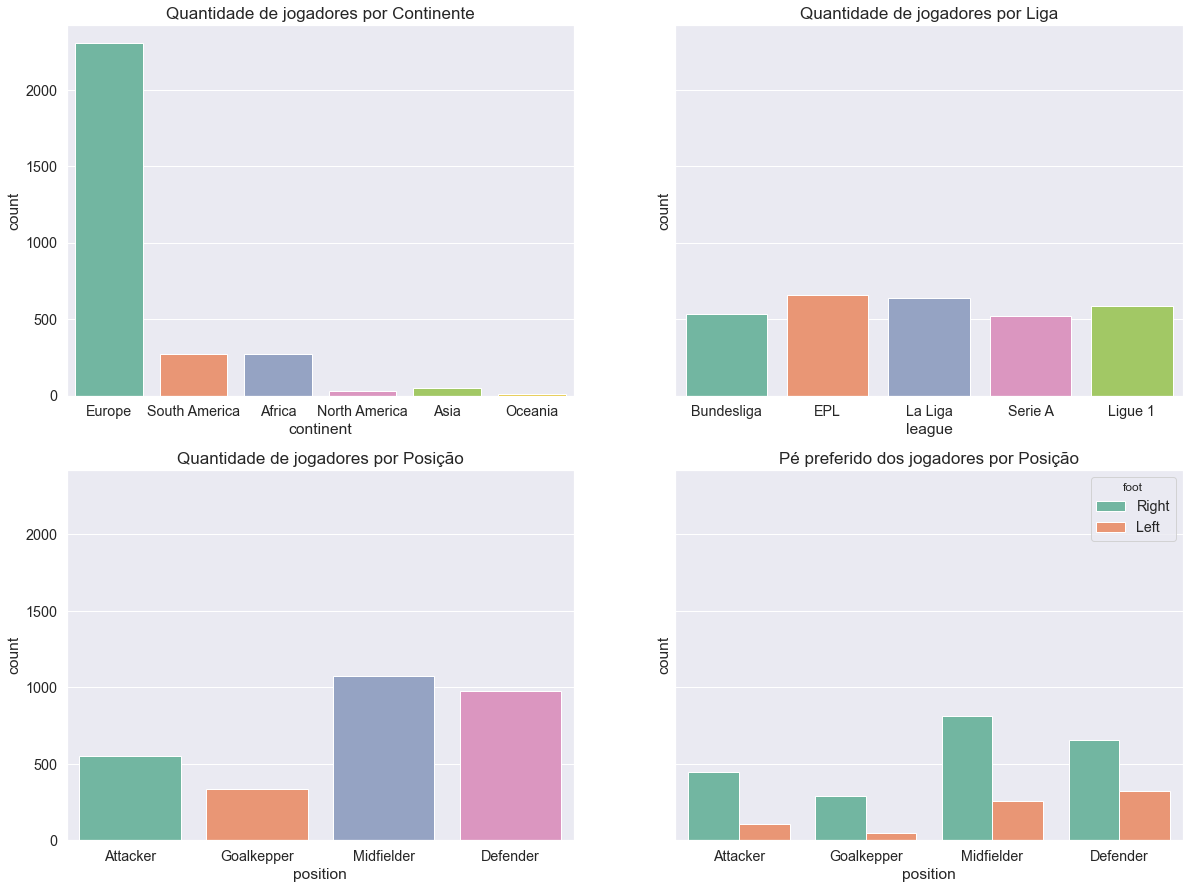

In [6]:
sns.set(font_scale=1.3)
fig, axes = plt.subplots(2, 2, figsize=(20, 15), sharey=True)

sns.countplot(ax=axes[0,0], x='continent', data=df, palette="Set2")
axes[0,0].set_title('Quantidade de jogadores por Continente', fontsize=17)

sns.countplot(ax=axes[0,1], x='league', data=df, palette="Set2")
axes[0,1].set_title('Quantidade de jogadores por Liga' , fontsize=17)

sns.countplot(ax=axes[1,0], x='position', data=df, palette="Set2")
axes[1,0].set_title('Quantidade de jogadores por Posição', fontsize=17)

sns.countplot(ax=axes[1,1], x='position', hue='foot', data=df, palette="Set2")
axes[1,1].set_title('Pé preferido dos jogadores por Posição', fontsize=17)

plt.show()

### 2.2. Mapa da quantidade de Jogadores por País

* Extraindo o código ISO de cada país e contando:

In [7]:
countries = pd.DataFrame(df['country'].value_counts())
countries.reset_index(level=0, inplace=True)
countries.columns = ['country', 'count']

c = countries['country'].values

iso_alpha = [pc.countries.search_fuzzy(name)[0].alpha_3 for name in c] 

countries['ISO'] = iso_alpha

In [8]:
countries.head()

,country,count,ISO
0,Spain,477,ESP
1,France,428,FRA
2,England,289,GBR
3,Germany,282,DEU
4,Italy,227,ITA


* Plotando o mapa:

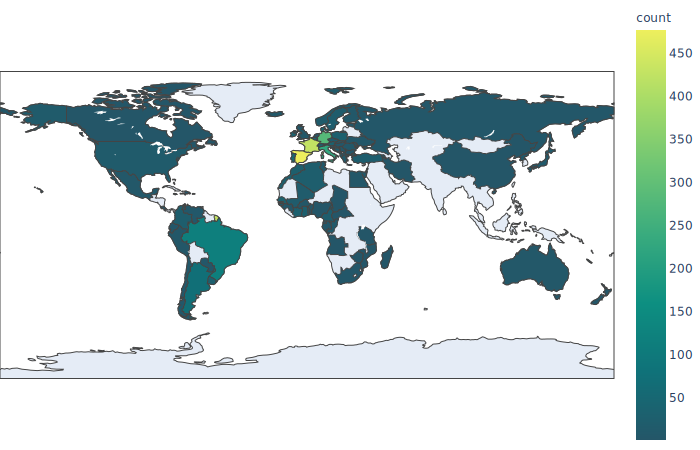

In [74]:
fig = px.choropleth(countries, locations="ISO",color="count",hover_name='country',
                    color_continuous_scale=px.colors.sequential.Aggrnyl)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show("svg")

### 2.3.  Violin Plot da Altura dos jogadores por Posição

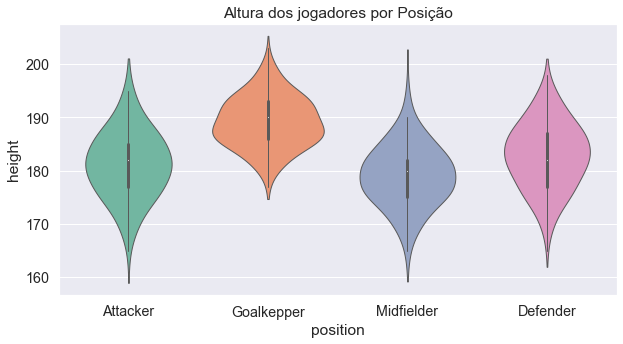

In [26]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='position', y='height', palette="Set2", bw=0.5, cut=1, linewidth=1)
plt.title('Altura dos jogadores por Posição')
plt.show()

### 2.4.  Violin Plot do Peso dos jogadores por Posição

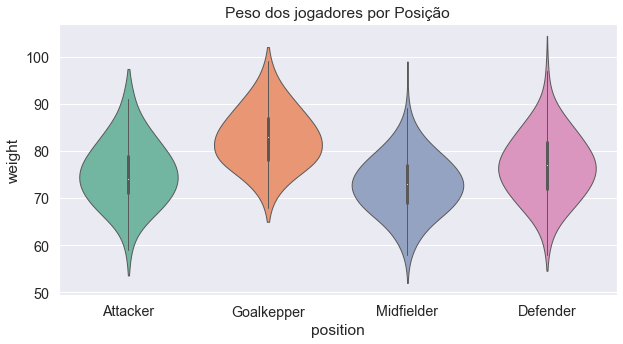

In [27]:
plt.figure(figsize=(10,5))
sns.violinplot(data=df, x='position', y='weight', palette="Set2", bw=0.5, cut=1, linewidth=1)
plt.title('Peso dos jogadores por Posição')
plt.show()

### 2.6. Distribuição da Idade dos jogadores

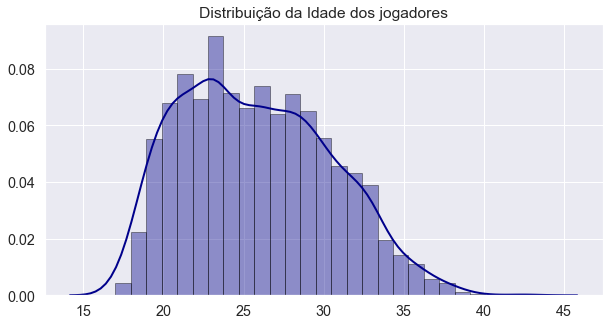

In [28]:
plt.figure(figsize=(10,5))
sns.distplot(df['age'].values, hist=True, kde=True, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2})
plt.title('Distribuição da Idade dos jogadores')
plt.show()

### 2.7. Distribuição da Idade dos jogadores por Posição

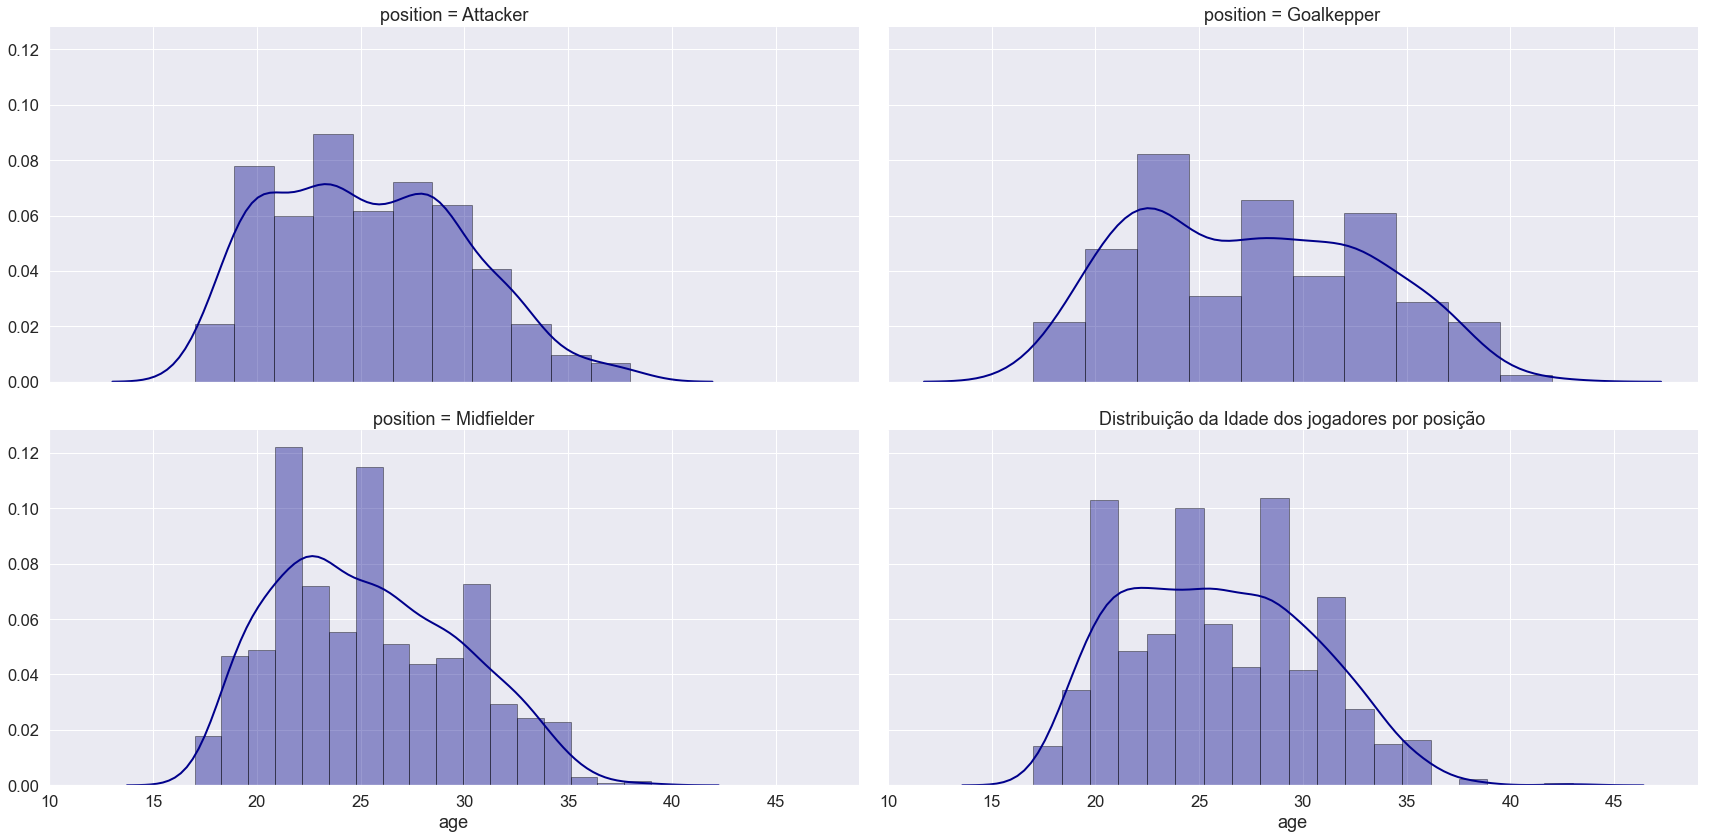

In [29]:
sns.set(font_scale=1.5)
g = sns.FacetGrid(df, col="position", height=6, aspect=2, col_wrap=2)
g.map(sns.distplot, "age", kde=True, color = 'darkblue', hist_kws={'edgecolor':'black'},kde_kws={'linewidth': 2})
g.add_legend()
plt.title('Distribuição da Idade dos jogadores por posição')
plt.show()

### 2.8. Salário em relação ao Valor de Mercado

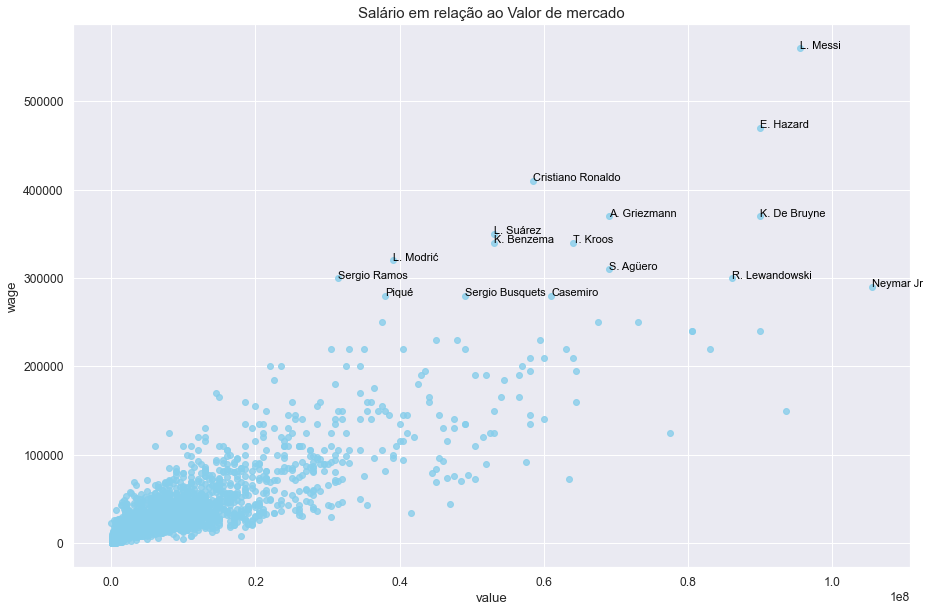

In [30]:
sns.set(font_scale=1.1)

df_value = df.copy()

plt.figure(figsize=(15,10))
p = sns.regplot(data=df, x="value", y="wage", fit_reg=False, color="skyblue")
plt.title('Salário em relação ao Valor de mercado', fontsize=15)

for line in range(0,df.shape[0]):
    if df.wage[line] > 250000:
        p.text(df.value[line]+0.2, df.wage[line], df.name[line], horizontalalignment='left', size='small', color='black')

### 2.9. Salário em relação ao Valor de Mercado, de acordo com a Liga

<Figure size 1080x1080 with 0 Axes>

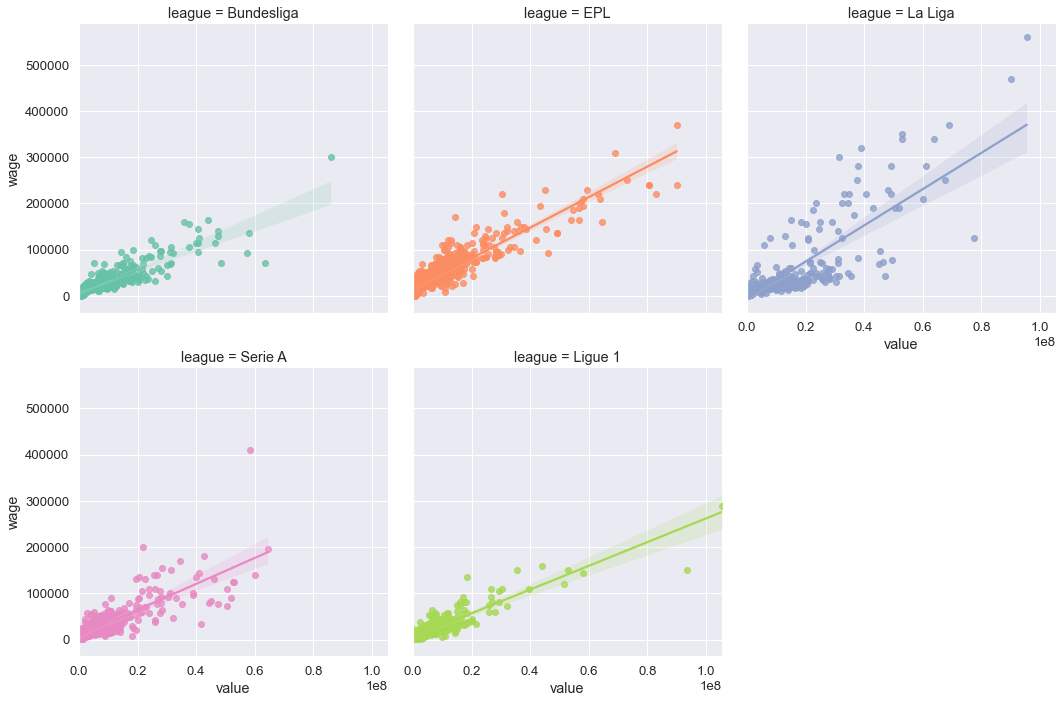

In [31]:
sns.set(font_scale=1.2)
plt.figure(figsize=(15,15))
sns.lmplot(x="value", y="wage", col="league", hue="league", palette="Set2", col_wrap=3, height=5, data=df)
plt.show()

### 2.10. Salário em relação ao Valor de Mercado, de acordo com a  Posição

<Figure size 1080x1080 with 0 Axes>

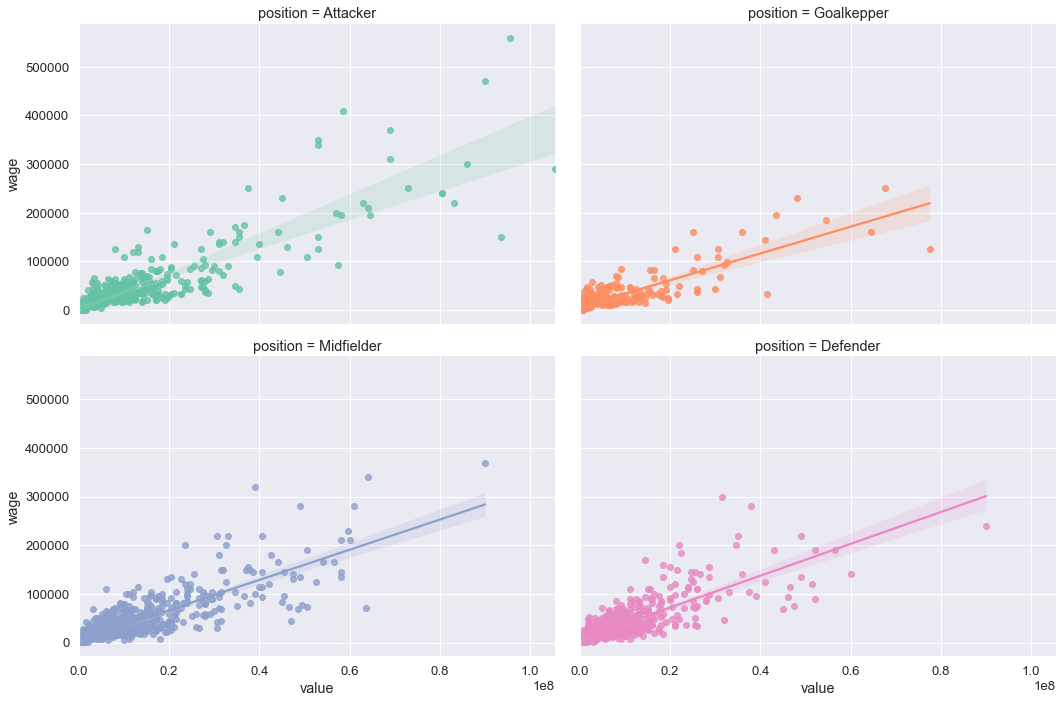

In [32]:
plt.figure(figsize=(15,15))
sns.lmplot(x="value", y="wage", col="position", hue="position", palette="Set2", col_wrap=2, height=5, aspect=1.5, data=df)
plt.show()